# 2.4 Graph Summary Statistics (Heterogeneous Ethereum Graph)

In this chapter, we compute a set of basic summary statistics on the heterogeneous Ethereum graph built in **2.3**.

We are interested in:
- Node and edge type breakdown
- Degree distributions (in-degree, out-degree, total degree)
- Connected components (weakly)
- Centrality measures (PageRank, HITS)
- Clustering coefficient on a sampled subgraph

The goal is to understand the overall structure of the heterogeneous graph before using it for higher-level analysis.


## 1. Imports + Load Graph

I'll load the heterogeneous Ethereum graph `G` that was built in **2.3** and saved to disk.

If you have not saved `G` yet, go back to **2.3** and run the last cell to save it.

In [7]:
import os
import sys

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)


In [ ]:
# Path to the heterogeneous graph file produced in 2.3
HETERO_GRAPH_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "heterogeneous_graph.gpickle")

if not os.path.exists(HETERO_GRAPH_PATH):
    raise FileNotFoundError(
        f"Cannot find heterogeneous graph file at {HETERO_GRAPH_PATH}.\n"
        "Please run 2.3 (Build the Heterogeneous Ethereum Graph) and save G first."
    )

with Path(HETERO_GRAPH_PATH).open("rb") as f:
    G = pickle.load(f)
print("Loaded heterogeneous graph G")
print("Directed:", G.is_directed())
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Loaded heterogeneous graph G
Directed: True
Nodes: 26447
Edges: 30638


## 2. Basic Node and Edge Statistics

We start with simple counts and type distributions:

- Total number of nodes and edges
- Number of nodes by `node_type` (EOA, Contract, Token Contract, etc.)
- Number of edges by `edge_type` (ETH transfer, token transfer, contract call, etc.), if available


In [10]:
# Total counts
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Total number of nodes:", num_nodes)
print("Total number of edges:", num_edges)


Total number of nodes: 26447
Total number of edges: 30638


In [11]:
# Node type distribution
node_types = pd.Series(
    (data.get("node_type", "Unknown") for _, data in G.nodes(data=True)),
    name="node_type"
)

node_type_counts = node_types.value_counts().sort_values(ascending=False)
print("Node type counts:")
display(node_type_counts.to_frame("count"))


Node type counts:


,count
node_type,
EOA,23619
Contract,2825
TokenContract,3


In [14]:
# Edge type distribution 

edge_types = pd.Series(
    (data.get("edge_type", "Unknown") for _, _, data in G.edges(data=True)),
    name="edge_type"
)

edge_type_counts = edge_types.value_counts().sort_values(ascending=False)
print("Edge type counts:")
display(edge_type_counts.to_frame("count"))

Edge type counts:


,count
edge_type,
TOKEN_TRANSFER,21418
ETH_TRANSFER,9220


## 3. Degree Distributions

For a directed heterogeneous graph, each address can have:

- **In-degree**: number of incoming edges
- **Out-degree**: number of outgoing edges
- **Total degree**: in-degree + out-degree

We first compute basic statistics (mean, std, etc.), and then visualize the distributions
using histograms and a log-log plot to check for heavy-tailed behavior.


In [15]:
# Compute in-degree, out-degree and total degree
in_deg_dict = dict(G.in_degree())
out_deg_dict = dict(G.out_degree())
deg_dict = dict(G.degree())

deg_df = pd.DataFrame({
    "in_degree": pd.Series(in_deg_dict),
    "out_degree": pd.Series(out_deg_dict),
    "degree": pd.Series(deg_dict),
})

deg_df = deg_df.fillna(0).astype(int)

print("Degree statistics (first 5 rows):")
display(deg_df.head())

print("\nDegree describe():")
display(deg_df.describe())


Degree statistics (first 5 rows):


,in_degree,out_degree,degree
0xd298c80f6e9e64a54b5a85b1733d76ee58837259,1,1,2
0xae9b92019f3e83d4451d48124f5abd8fc3124de6,1,2,3
0xd8193304176033a5f48976d1881bdd46d36c8523,1,1,2
0x0d8af920bb569f8a7d45485581dd989a7b14d390,1,0,1
0xf78abd170cff445fefe7248336b55e2c18906f00,1,0,1



Degree describe():


,in_degree,out_degree,degree
count,26447.000000,26447.000000,26447.000000
mean,1.158468,1.158468,2.316936
std,89.961732,2.881189,90.037702
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000
75%,0.000000,1.000000,1.000000
max,11228.000000,320.000000,11228.000000


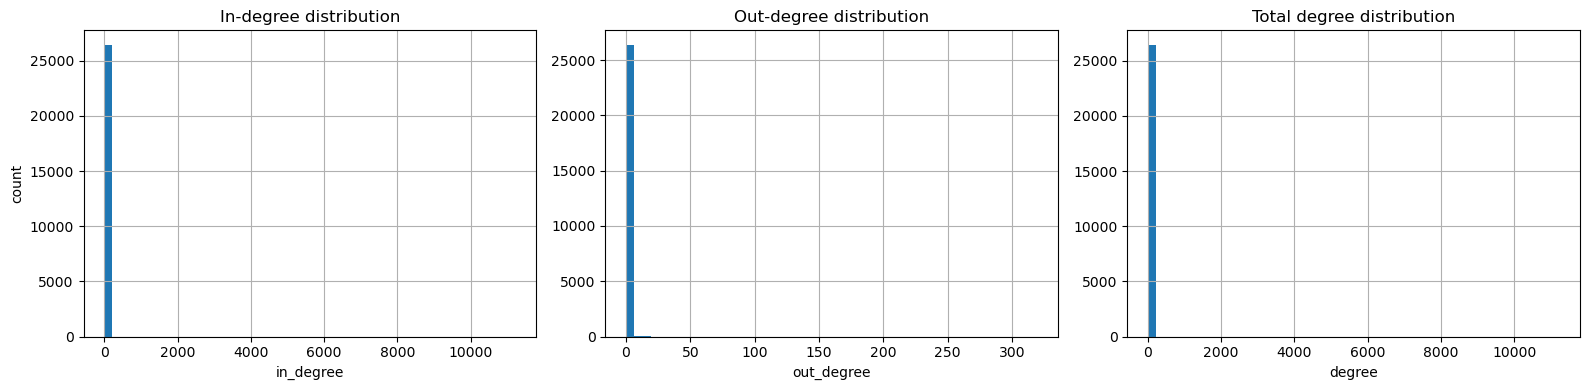

In [16]:
# Histogram of in-degree, out-degree and total degree

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(deg_df["in_degree"], bins=50)
axes[0].set_title("In-degree distribution")
axes[0].set_xlabel("in_degree")
axes[0].set_ylabel("count")

axes[1].hist(deg_df["out_degree"], bins=50)
axes[1].set_title("Out-degree distribution")
axes[1].set_xlabel("out_degree")

axes[2].hist(deg_df["degree"], bins=50)
axes[2].set_title("Total degree distribution")
axes[2].set_xlabel("degree")

plt.tight_layout()
plt.show()


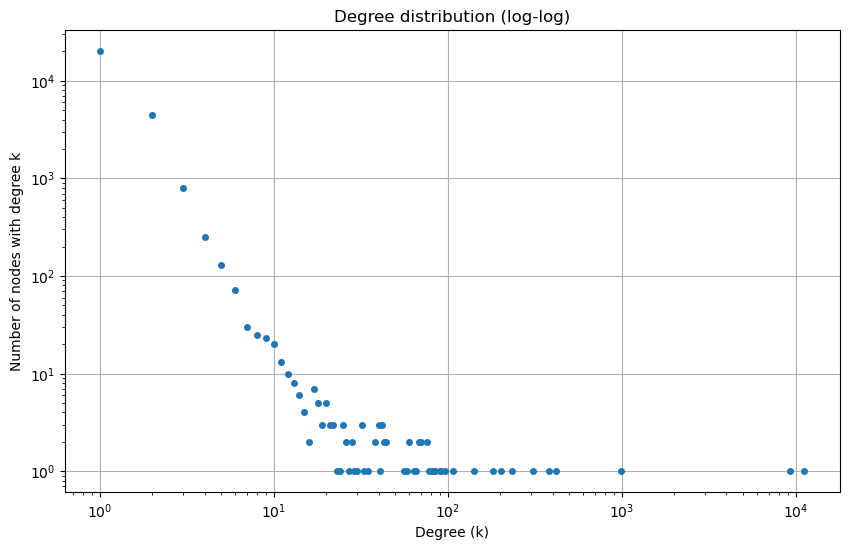

In [17]:
# Log-log plot of the degree distribution (k -> #nodes with degree k)

deg_counts = deg_df["degree"].value_counts().sort_index()
deg_counts = deg_counts[deg_counts.index > 0]  # remove degree 0 for log-log

plt.figure()
plt.loglog(deg_counts.index, deg_counts.values, "o", markersize=4, linestyle="none")
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title("Degree distribution (log-log)")
plt.grid(True)
plt.show()


## 4. Connected Components

The heterogeneous Ethereum graph is directed.

Some nodes have no outgoing edges, and others may be weakly but not strongly connected.

We therefore focus on **weakly connected components (WCCs)**:

- Number of WCCs
- Size distribution of WCCs
- Extract the largest WCC as a subgraph `G_lcc` for later analysis


In [18]:
# Weakly connected components

if G.is_directed():
    components = list(nx.weakly_connected_components(G))
else:
    components = list(nx.connected_components(G))

num_components = len(components)
component_sizes = sorted((len(c) for c in components), reverse=True)

print("Number of weakly connected components:", num_components)
print("Largest 10 component sizes:", component_sizes[:10])

largest_cc_nodes = max(components, key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

print("\nLargest WCC:")
print("Nodes:", G_lcc.number_of_nodes())
print("Edges:", G_lcc.number_of_edges())


Number of weakly connected components: 773
Largest 10 component sizes: [25103, 17, 12, 11, 9, 9, 9, 8, 7, 7]

Largest WCC:
Nodes: 25103
Edges: 30043


## 5. Centrality Measures (PageRank and HITS)

To identify important nodes in the heterogeneous graph, we compute:

- **PageRank**: importance in terms of incoming "flow"
- **HITS** (hubs and authorities): nodes that point to many important nodes (hubs) and nodes that are pointed to by many important nodes (authorities)

For performance reasons, we run these algorithms on the **largest WCC (`G_lcc`)**.


In [19]:
# PageRank on the largest WCC

alpha = 0.85
print(f"Computing PageRank on G_lcc (alpha={alpha}) ...")

pr = nx.pagerank(G_lcc, alpha=alpha, max_iter=100)

pr_series = pd.Series(pr, name="pagerank").sort_values(ascending=False)

top_k = 20
top_pr = pr_series.head(top_k).to_frame()

# Add node_type if available
node_type_map = dict(G_lcc.nodes(data="node_type"))
top_pr["node_type"] = top_pr.index.map(lambda n: node_type_map.get(n, "Unknown"))

print(f"Top {top_k} nodes by PageRank:")
display(top_pr)


Computing PageRank on G_lcc (alpha=0.85) ...
Top 20 nodes by PageRank:


,pagerank,node_type
0xdac17f958d2ee523a2206206994597c13d831ec7,0.174032,TokenContract
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0.142892,TokenContract
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.016451,TokenContract
0x28c6c06298d514db089934071355e5743bf21d60,0.010081,EOA
0x00000000219ab540356cbb839cbe05303d7705fa,0.006288,Contract
0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,0.004862,EOA
0xf30ba13e4b04ce5dc4d254ae5fa95477800f0eb0,0.003148,EOA
0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,0.002680,Contract
0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,0.002545,EOA
0x2cff890f0378a11913b6129b2e97417a2c302680,0.002110,EOA


In [20]:
# HITS on the largest WCC

print("Computing HITS on G_lcc ...")
hubs, authorities = nx.hits(G_lcc, max_iter=100, normalized=True)

hubs_s = pd.Series(hubs, name="hub_score").sort_values(ascending=False)
auth_s = pd.Series(authorities, name="authority_score").sort_values(ascending=False)

top_k = 20

top_hubs = hubs_s.head(top_k).to_frame()
top_hubs["node_type"] = top_hubs.index.map(lambda n: node_type_map.get(n, "Unknown"))

top_auth = auth_s.head(top_k).to_frame()
top_auth["node_type"] = top_auth.index.map(lambda n: node_type_map.get(n, "Unknown"))

print(f"Top {top_k} hubs:")
display(top_hubs)

print(f"\nTop {top_k} authorities:")
display(top_auth)


Computing HITS on G_lcc ...
Top 20 hubs:


,hub_score,node_type
0xc6afe61b3269ac6b592660265bbe111940992b66,0.000099,EOA
0x59d4f7599e31417b9a3b6d8483cf795e0b05eb2e,0.000099,EOA
0x896b6b09f2604f8da84ace6ae39c722f68e4e215,0.000099,EOA
0xf5213a6a2f0890321712520b8048d9886c1a9900,0.000099,EOA
0xef1ec136931ab5728b0783fd87d109c9d15d31f1,0.000099,EOA
0x699ee12a1d97437a4a1e87c71e5d882b3881e2e3,0.000099,EOA
0xf70da97812cb96acdf810712aa562db8dfa3dbef,0.000097,EOA
0x3b15cec2d922ab0ef74688bcc1056461049f89cb,0.000097,EOA
0x5745050e787f693ed21e4418d528f78ad9c374a6,0.000097,Contract
0xba12222222228d8ba445958a75a0704d566bf2c8,0.000097,Contract



Top 20 authorities:


,authority_score,node_type
0xdac17f958d2ee523a2206206994597c13d831ec7,0.555598,TokenContract
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0.309712,TokenContract
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.020814,TokenContract
0x28c6c06298d514db089934071355e5743bf21d60,0.003602,EOA
0x03f34be1bf910116595db1b11e9d1b2ca5d59659,0.001460,Contract
0xd01607c3c5ecaba394d8be377a08590149325722,0.001459,Contract
0x66a9893cc07d91d95644aedd05d03f95e1dba8af,0.001132,Contract
0xf30ba13e4b04ce5dc4d254ae5fa95477800f0eb0,0.000805,EOA
0xba3cb449bd2b4adddbc894d8697f5170800eadec,0.000802,Contract
0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,0.000715,EOA


## 6. Clustering Coefficient (Sampled Subgraph)

Computing clustering coefficients on the full heterogeneous graph can be expensive.

Instead, we:

1. Sample up to a fixed number of nodes from the largest WCC
2. Convert the sampled subgraph to an undirected simple graph
3. Compute the **average clustering coefficient**

This gives a rough idea of how "triangular" or "locally clustered" the network is.


In [21]:
# Sampled clustering coefficient

MAX_SAMPLE_NODES = 5000

if G_lcc.number_of_nodes() > MAX_SAMPLE_NODES:
    sample_nodes = np.random.choice(list(G_lcc.nodes()), size=MAX_SAMPLE_NODES, replace=False)
    G_sample = G_lcc.subgraph(sample_nodes).copy()
    print(f"Using sampled subgraph with {G_sample.number_of_nodes()} nodes for clustering.")
else:
    G_sample = G_lcc
    print("Using full largest WCC for clustering.")

# Convert to undirected simple graph
G_und = nx.Graph(G_sample)

avg_clustering = nx.average_clustering(G_und)
print(f"Average clustering coefficient (sampled): {avg_clustering:.6f}")


Using sampled subgraph with 5000 nodes for clustering.
Average clustering coefficient (sampled): 0.000000


## 7. Summary

In this notebook, we:

- Loaded the heterogeneous Ethereum graph `G`
- Computed basic node and edge statistics, including type distributions
- Analyzed degree distributions (histograms and log-log plot)
- Studied weakly connected components and extracted the largest WCC
- Ran PageRank and HITS centrality on the largest WCC
- Estimated the average clustering coefficient on a sampled subgraph

These summary statistics help us understand the global structure of the heterogeneous graph and will guide further analysis and visualization in **2.5**.
